--- Loading all required datasets ---


Ignoring index file 'C:\\Users\\esthe\\Documents\\programming\\climarisc\\data\\climate_monthly_full\\era5_land_monthly_1981.grib.47d85.idx' incompatible with GRIB file
C:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:\\Users\\esthe\\Documents\\programming\\climarisc\\data\\climate_mont

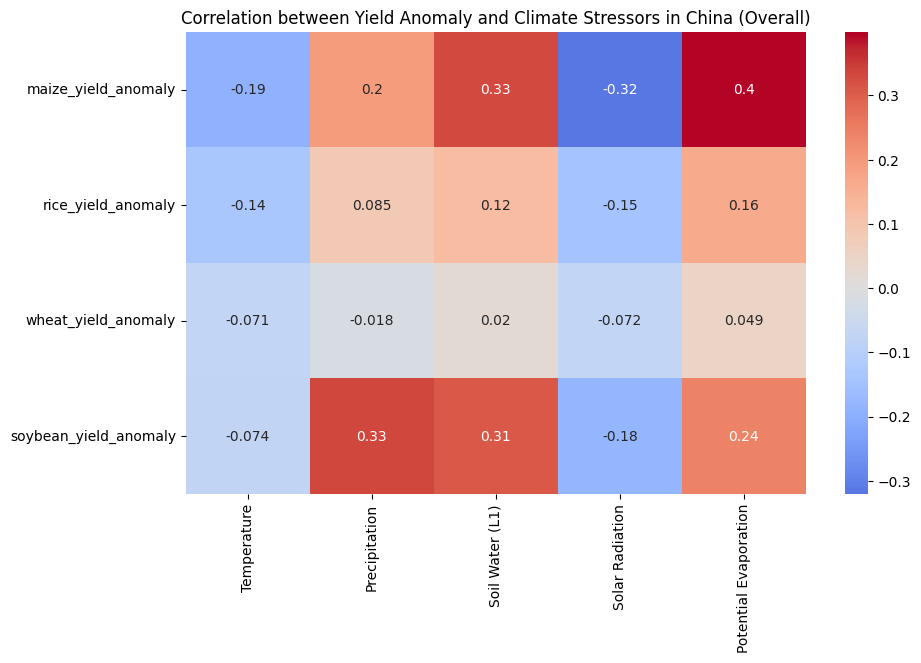

In [1]:
# Cell 1: Italy Correlation Analysis (Corrected Aggregation)
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend

# --- 1. Load All Data ---
print("--- Loading all required datasets ---")
CROPS = ['maize', 'rice', 'wheat', 'soybean']
full_yields = {crop: xr.open_mfdataset(f'../data/{crop}/yield_*.nc4', combine='nested', concat_dim='time')['var'].compute() for crop in CROPS}
STRESSORS = {'2t': 'Temperature', 'tp': 'Precipitation', 'swvl1': 'Soil Water (L1)', 'ssr': 'Solar Radiation', 'pev': 'Potential Evaporation'}
full_climate = {short_name: xr.open_mfdataset(f'../data/climate_monthly_full/era5_land_monthly_*.grib', engine='cfgrib', combine='nested', concat_dim='time', backend_kwargs={'filter_by_keys': {'shortName': short_name}}) for short_name in STRESSORS.keys()}
for ds in full_climate.values(): ds.time.values[:] = pd.to_datetime(ds.time.values)

# --- 2. Define Regions and Growing Season ---
climate_region = {'longitude': slice(73, 135), 'latitude': slice(54, 18)}
yield_region = {'lon': slice(73, 135), 'lat': slice(18, 54)}
temp_celsius = full_climate['2t']['t2m'] - 273.15
growing_season_mask = temp_celsius > 10

# --- 3. Calculate Regional Time-Series ---
all_series = {}
# Yield Anomalies
for crop in CROPS:
    regional_yield = full_yields[crop].sel(**yield_region)
    if regional_yield.notnull().any():
        weights = np.cos(np.deg2rad(regional_yield.lat))
        yield_ts = regional_yield.weighted(weights).mean(dim=('lat', 'lon'))
        if yield_ts.isnull().any():
            all_series[f'{crop}_yield_anomaly'] = (yield_ts - yield_ts.mean()).values
        else:
            all_series[f'{crop}_yield_anomaly'] = detrend(yield_ts.values)

# Climate Stressors
for short_name, long_name in STRESSORS.items():
    var_name = list(full_climate[short_name].data_vars)[0]
    regional_climate = full_climate[short_name][var_name].sel(**climate_region)
    seasonal_data = regional_climate.where(growing_season_mask.sel(**climate_region))
    agg_method = 'sum' if short_name == 'tp' else 'mean'
    
    # --- THIS IS THE CORRECTED LOGIC ---
    grouped_by_year = seasonal_data.groupby('time.year')
    if agg_method == 'sum':
        yearly_agg = grouped_by_year.sum(dim='time')
    else: # agg_method is 'mean'
        yearly_agg = grouped_by_year.mean(dim='time')
    yearly_stressor = yearly_agg.mean(dim=['latitude', 'longitude'])
    # --- END CORRECTION ---

    if short_name == '2t': yearly_stressor -= 273.15
    if short_name == 'tp': yearly_stressor *= 1000
    all_series[long_name] = yearly_stressor.values

# --- 4. Create and Plot Correlation Matrix ---
df_italy = pd.DataFrame(all_series)
corr_matrix = df_italy.corr()
yield_stressor_corr = corr_matrix.loc[[c for c in df_italy.columns if 'yield' in c], [c for c in df_italy.columns if 'yield' not in c]]
plt.figure(figsize=(10, 6))
sns.heatmap(yield_stressor_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Yield Anomaly and Climate Stressors in China (Overall)')
plt.show()

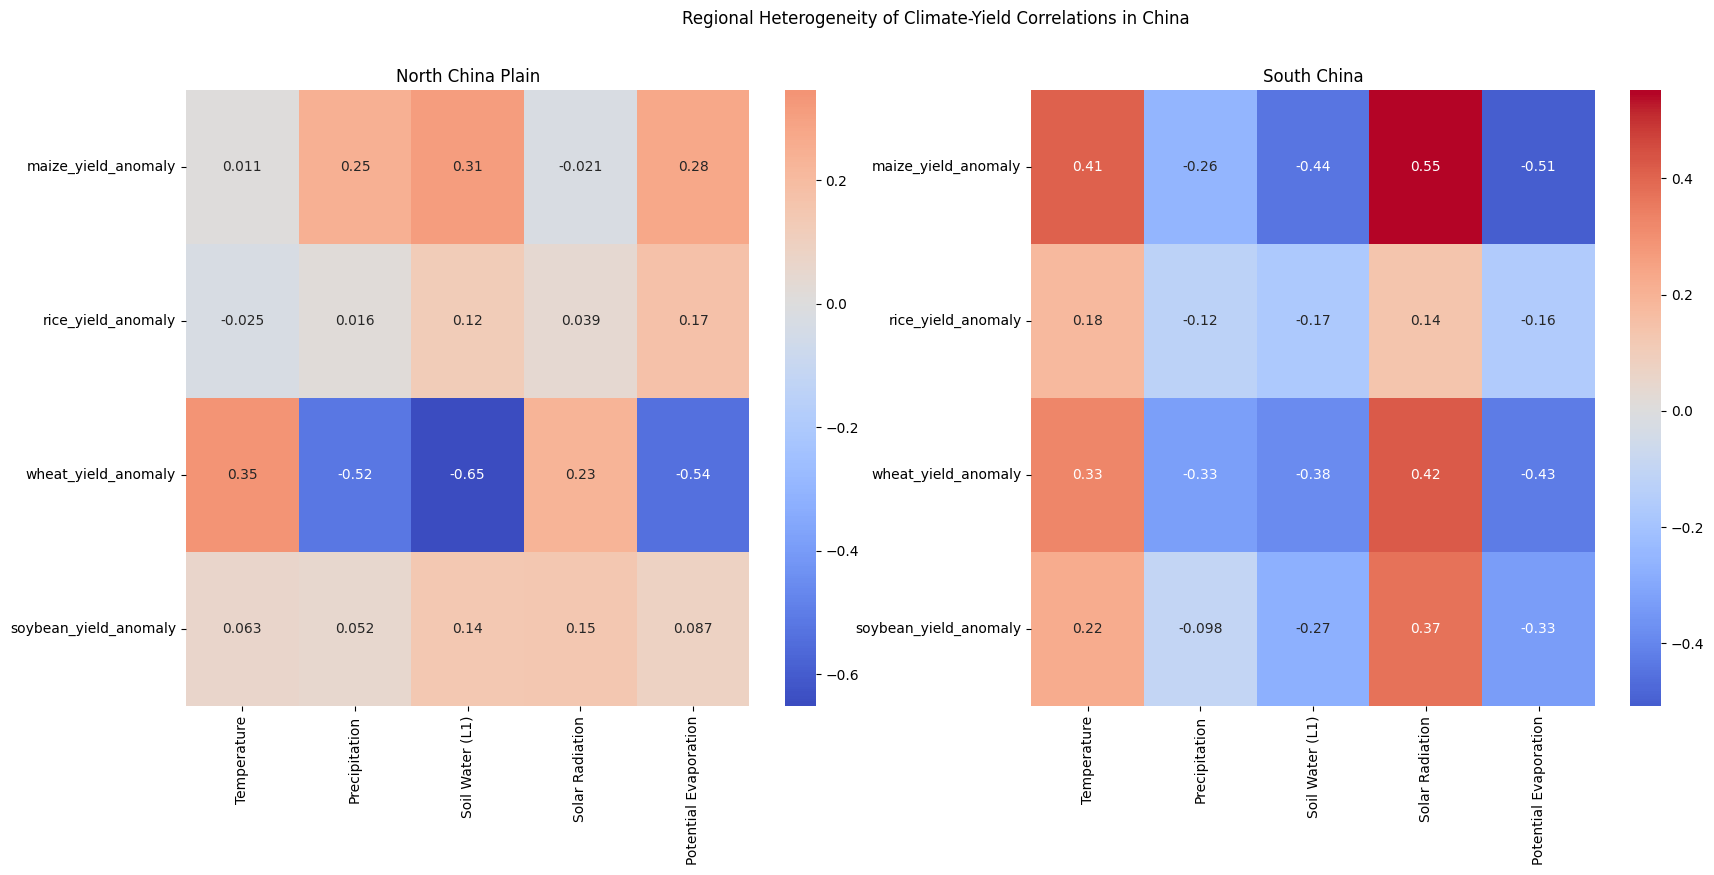

In [3]:
# Cell 2: North vs. South China Comparison (Corrected)
import pandas as pd
from scipy.signal import detrend
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define North and South Bounding Boxes ---
# North China Plain (Wheat/Maize belt)
climate_north = {'longitude': slice(110, 122), 'latitude': slice(42, 32)}
yield_north = {'lon': slice(110, 122), 'lat': slice(32, 42)}
# South China (Rice belt)
climate_south = {'longitude': slice(105, 122), 'latitude': slice(32, 22)}
yield_south = {'lon': slice(105, 122), 'lat': slice(22, 32)}

# --- Function to generate a correlation matrix for a sub-region ---
def generate_regional_corr(yield_bounds, climate_bounds):
    all_series = {}
    for crop in CROPS:
        regional_yield = full_yields[crop].sel(**yield_bounds)
        if regional_yield.notnull().any():
            weights = np.cos(np.deg2rad(regional_yield.lat))
            yield_ts = regional_yield.weighted(weights).mean(dim=('lat', 'lon'))
            if yield_ts.isnull().any():
                all_series[f'{crop}_yield_anomaly'] = (yield_ts - yield_ts.mean()).values
            else:
                all_series[f'{crop}_yield_anomaly'] = detrend(yield_ts.values)
    
    for short_name, long_name in STRESSORS.items():
        var_name = list(full_climate[short_name].data_vars)[0]
        regional_climate = full_climate[short_name][var_name].sel(**climate_bounds)
        seasonal_data = regional_climate.where(growing_season_mask.sel(**climate_bounds))
        agg_method = 'sum' if short_name == 'tp' else 'mean'
        
        # --- THIS IS THE CORRECTED LOGIC (Copied from Cell 1) ---
        grouped_by_year = seasonal_data.groupby('time.year')
        if agg_method == 'sum':
            yearly_agg = grouped_by_year.sum(dim='time')
        else: # agg_method is 'mean'
            yearly_agg = grouped_by_year.mean(dim='time')
        yearly_stressor = yearly_agg.mean(dim=['latitude', 'longitude'])
        # --- END CORRECTION ---

        if short_name == '2t': yearly_stressor -= 273.15
        if short_name == 'tp': yearly_stressor *= 1000
        all_series[long_name] = yearly_stressor.values
        
    return pd.DataFrame(all_series).corr()

# --- Generate and Plot Both Matrices ---
corr_north = generate_regional_corr(yield_north, climate_north)
corr_south = generate_regional_corr(yield_south, climate_south)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(corr_north.loc[[c for c in corr_north.columns if 'yield' in c], [c for c in corr_north.columns if 'yield' not in c]],
            annot=True, cmap='coolwarm', center=0, ax=ax1)
ax1.set_title('North China Plain')

sns.heatmap(corr_south.loc[[c for c in corr_south.columns if 'yield' in c], [c for c in corr_south.columns if 'yield' not in c]],
            annot=True, cmap='coolwarm', center=0, ax=ax2)
ax2.set_title('South China')

plt.suptitle('Regional Heterogeneity of Climate-Yield Correlations in China')
plt.show()